In [386]:
import pandas as pd
import numpy as np

In [387]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [388]:
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [389]:
sns.set(rc={'figure.figsize':(9,6)}) #для  изменения масштаба фигуры

In [390]:
event_data = pd.read_csv('event_data_train.csv')
event_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [391]:
event_data['date'] = pd.to_datetime(event_data.timestamp, unit = 's')
event_data['day'] = event_data.date.dt.date
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [392]:
event_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [393]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [394]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


<AxesSubplot:xlabel='day'>

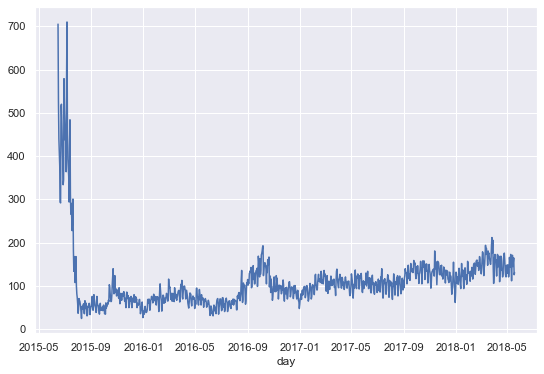

In [395]:
event_data.groupby('day').user_id.nunique().plot()

<AxesSubplot:>

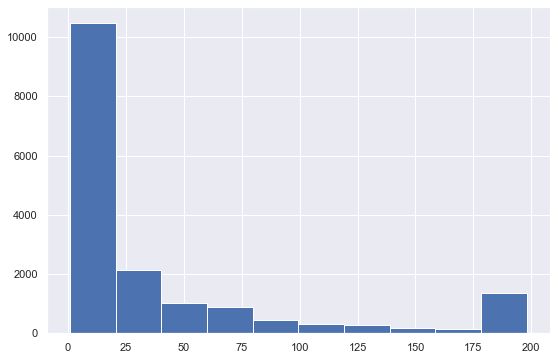

In [396]:
event_data[event_data.action == 'passed'].groupby('user_id', as_index = False)\
    .agg({'step_id':'count'})\
    .rename(columns = {'step_id': 'passed_steps'}).passed_steps.hist()
#неверно.тк не учитываются те у кого нет ни одного passed

# users_event_data показывает кол-во action у каждого user_id из табл event_data

In [397]:
users_event_data = event_data.pivot_table(index = 'user_id', columns = 'action', values = 'step_id', aggfunc = 'count', fill_value = 0)\
.reset_index()
users_event_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<AxesSubplot:>

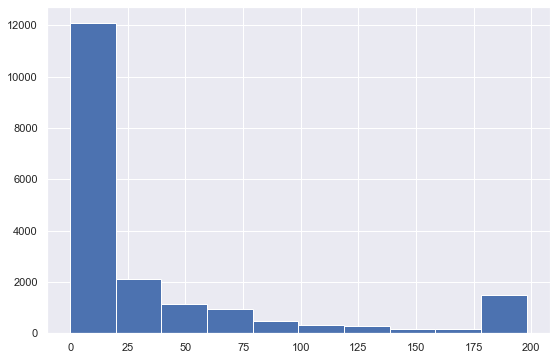

In [398]:
event_data.pivot_table(index = 'user_id', columns = 'action', values = 'step_id', aggfunc = 'count', fill_value = 0)\
.reset_index().discovered.hist()

# users_scores табл показывет кол-во correct&wrong answers from subbmissions_data table

In [399]:
users_scores = submissions_data.pivot_table(index = 'user_id', columns = 'submission_status', values = 'step_id'\
     , aggfunc = 'count', fill_value = 0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


# gap_data показывает после какого дня человек не вернется на курс(30 дней)

In [400]:
event_data.head()  

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [401]:
gap_data = event_data[['user_id','day','timestamp']].drop_duplicates(subset=['user_id','day'])\
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values
gap_data     #находим перерывы. которые совершал пользователь
    

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
          98252,    57019]),
       array([1567990]), array([], dtype=int32)], dtype=object)

In [402]:
gap_data = pd.Series(np.concatenate(gap_data,axis = None))
gap_data = gap_data / (24*60*60)   #переводим в дни
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

<AxesSubplot:>

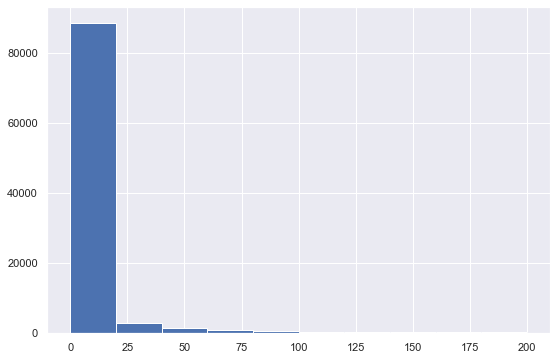

In [403]:
gap_data[gap_data < 200].hist()

In [404]:
gap_data.quantile(0.95)

59.760440972222156

In [405]:
gap_data.quantile(0.90)

18.325995370370403

# users_data добавляем колонку.которая показывает last_timestamp>30 day or not

In [406]:
30*24*60*60
#timestamp в 30 дней.переведенный в секунды(считается что если пользователь не появлялся больше 30 дней то он drop)

2592000

In [407]:
event_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [408]:
now = 1526772685
drop_out_threshold = 2592000 #30 дней

In [409]:
users_data = event_data.groupby('user_id', as_index = False) \
    .agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})
users_data.head()
#последний  timestamp. когда пользователь появлялся

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [410]:
users_data['is_gone_users'] = (now - users_data.last_timestamp) > drop_out_threshold  
users_data.head()
#смотрим последний timestamp больше или меньше 30 дней(если больше то типо он drop, но нужно еще смотреть на сертификаты)

,user_id,last_timestamp,is_gone_users
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


# users_data JOIN with users_scores

In [411]:
user_data = users_data.merge(users_scores, on = 'user_id', how = 'outer').fillna(0)


In [412]:
user_data.head()

,user_id,last_timestamp,is_gone_users,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


# user_data Join with users_event_data

In [413]:
users_data_finish = user_data.merge(users_event_data,on = 'user_id', how = 'outer').fillna(0)


In [414]:
users_data_finish.head()

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


# сколько уникальных дней пользователь был на Stepik

In [415]:
users_day = event_data.groupby('user_id').day.nunique().to_frame().reset_index()


In [416]:
users_day.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


# users_data_finish JOIN with users_day

In [417]:
users_data_finish = users_data_finish.merge(users_day,on = 'user_id', how = 'outer')


In [418]:
users_data_finish.head()

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [419]:
users_data_finish.user_id.nunique()

19234

In [420]:
event_data.user_id.nunique()

19234

# колонка passed_course показывается есть сертификат или нет

In [421]:
users_data_finish['passed_course'] = users_data_finish.passed > 40

In [422]:
users_data_finish.head()

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,True
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [423]:
users_data_finish.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,14596,14596,14596,14596,14596,14596,14596,14596,14596,14596
True,4638,4638,4638,4638,4638,4638,4638,4638,4638,4638


In [424]:
100*1425/17809

8.001572238755685

In [425]:
users_data_finish[users_data_finish.passed_course].day.median()   # сколько дней пользователь потратил на прохождение курса

13.0

<AxesSubplot:>

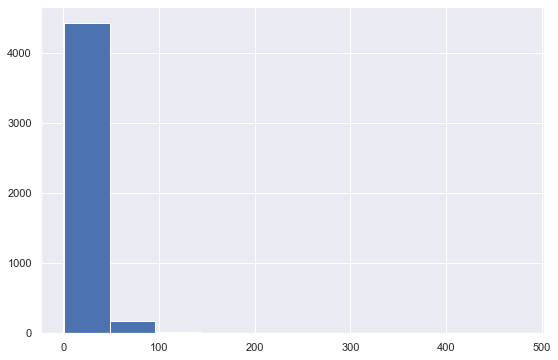

In [426]:
users_data_finish[users_data_finish.passed_course].day.hist()

# добавили min_timestamp (первый день на курсе) 

In [427]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [428]:
user_min_time = event_data.groupby('user_id', as_index = False).agg({'timestamp':"min"})\
                    .rename({'timestamp':'min_timestamp'}, axis=1)

In [429]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [430]:
users_data_finish = users_data_finish.merge(user_min_time, how='outer')

In [431]:
users_data_finish.head()

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,True,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [432]:
users_data_finish.user_id.nunique()

19234

# отбираем данные за 2 дня

In [433]:
event_data['user_time'] = event_data.user_id.map(str)+'_'+event_data.timestamp.map(str)

In [434]:
event_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [435]:
learning_time_threshold = 2*24*60*60    #2days

In [436]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [437]:
users_learning_time_threshold = user_min_time.user_id.map(str)+'_'+(user_min_time.min_timestamp + learning_time_threshold).map(str)

In [438]:
users_learning_time_threshold.head()

0    1_1473000264
1    2_1514556164
2    3_1434531276
3    5_1466329609
4    7_1521807460
dtype: object

In [439]:
user_min_time['users_learning_time_threshold'] = users_learning_time_threshold   #2 days

In [440]:
user_min_time.head()

,user_id,min_timestamp,users_learning_time_threshold
0,1,1472827464,1_1473000264
1,2,1514383364,2_1514556164
2,3,1434358476,3_1434531276
3,5,1466156809,5_1466329609
4,7,1521634660,7_1521807460


In [441]:
event_data.shape

(3480703, 7)

In [442]:
event_data = event_data.merge(user_min_time[['user_id','users_learning_time_threshold']],how = 'outer')

In [443]:
event_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,users_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648


In [444]:
event_data.shape

(3480703, 8)

In [445]:
events_data_train = event_data[event_data.user_time <= event_data.users_learning_time_threshold]

In [446]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,users_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434513648
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434513648


In [447]:
events_data_train.groupby('user_id').day.nunique().max()

3

# Отбираем данные за 2 дня в submission data

In [448]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [449]:
submissions_data['user_time'] = submissions_data.user_id.map(str) +'_' + submissions_data.timestamp.map(str)

In [450]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,15853_1478852149
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,15853_1478852164
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123


In [451]:
submissions_data.shape

(509104, 7)

In [452]:
submissions_data = submissions_data.merge(user_min_time[['user_id','users_learning_time_threshold']],how = 'outer')

In [453]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,users_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434518777
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434518777
2,31972.0,1.478852e+09,wrong,15853,2016-11-11 08:15:49,2016-11-11,15853_1478852149,15853_1434518777
3,31972.0,1.478852e+09,correct,15853,2016-11-11 08:16:04,2016-11-11,15853_1478852164,15853_1434518777
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434518777


In [454]:
submissions_data.shape

(518398, 8)

In [455]:
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.users_learning_time_threshold]

In [456]:
submissions_data_train.shape

(115466, 8)

In [457]:
submissions_data_train.groupby('user_id').day.nunique().max()

3

In [458]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
        .rename(columns={'day':'days'})

In [459]:
X.shape

(8815, 2)

In [460]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,2


In [461]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
            .rename(columns={'step_id':'steps_tried'})

In [462]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,18


In [463]:
X = X.merge(steps_tried, on = 'user_id', how = 'outer')

In [464]:
X.shape

(8815, 3)

In [465]:
X = X.merge(submissions_data_train.pivot_table(index = 'user_id', columns = 'submission_status', values = 'step_id'\
     , aggfunc = 'count', fill_value = 0).reset_index())

In [466]:
X.shape

(8815, 5)

In [467]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,2,18,18,23


In [468]:
X['correst_ratio'] = X.correct / (X.correct+X.wrong)

In [469]:
X.head()

,user_id,days,steps_tried,correct,wrong,correst_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,2,18,18,23,0.439024


In [470]:
X = X.merge(events_data_train.pivot_table(index = 'user_id',
                                         columns = 'action',
                                         values = 'step_id',
                                         aggfunc = 'count',
                                         fill_value = 0)\
            .reset_index()[['user_id','viewed','passed']], how = 'outer')


In [471]:

X.head()

,user_id,days,steps_tried,correct,wrong,correst_ratio,viewed,passed
0,2,1.0,2.0,2.0,0.0,1.000000,9,9
1,3,1.0,4.0,4.0,4.0,0.500000,20,15
2,8,1.0,11.0,9.0,21.0,0.300000,154,84
3,14,1.0,1.0,0.0,1.0,0.000000,9,3
4,16,2.0,18.0,18.0,23.0,0.439024,117,49


In [472]:
X.shape

(19234, 8)

In [473]:
users_data_finish.head()

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,True,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [474]:
X = X.merge(users_data_finish[['user_id','passed_course','is_gone_users']], how = 'outer')

In [475]:
X.shape

(19234, 10)

In [476]:
X.head()

,user_id,days,steps_tried,correct,wrong,correst_ratio,viewed,passed,passed_course,is_gone_users
0,2,1.0,2.0,2.0,0.0,1.000000,9,9,False,True
1,3,1.0,4.0,4.0,4.0,0.500000,20,15,True,True
2,8,1.0,11.0,9.0,21.0,0.300000,154,84,True,True
3,14,1.0,1.0,0.0,1.0,0.000000,9,3,False,True
4,16,2.0,18.0,18.0,23.0,0.439024,117,49,True,True


In [477]:
X = X[~((X.is_gone_users == False) & (X.passed_course == False))] #все кроме данной комбинации False False(то есть без тех кто в процессе)

In [478]:
X.head()

,user_id,days,steps_tried,correct,wrong,correst_ratio,viewed,passed,passed_course,is_gone_users
0,2,1.0,2.0,2.0,0.0,1.000000,9,9,False,True
1,3,1.0,4.0,4.0,4.0,0.500000,20,15,True,True
2,8,1.0,11.0,9.0,21.0,0.300000,154,84,True,True
3,14,1.0,1.0,0.0,1.0,0.000000,9,3,False,True
4,16,2.0,18.0,18.0,23.0,0.439024,117,49,True,True


In [479]:
X = X.dropna()
X

,user_id,days,steps_tried,correct,wrong,correst_ratio,viewed,passed,passed_course,is_gone_users
0,2,1.0,2.0,2.0,0.0,1.000000,9,9,False,True
1,3,1.0,4.0,4.0,4.0,0.500000,20,15,True,True
2,8,1.0,11.0,9.0,21.0,0.300000,154,84,True,True
3,14,1.0,1.0,0.0,1.0,0.000000,9,3,False,True
4,16,2.0,18.0,18.0,23.0,0.439024,117,49,True,True
...,...,...,...,...,...,...,...,...,...,...
8810,26786,1.0,1.0,1.0,0.0,1.000000,23,12,False,True
8811,26787,1.0,3.0,3.0,0.0,1.000000,14,13,False,True
8812,26794,2.0,22.0,24.0,7.0,0.774194,90,50,True,True
8813,26797,1.0,2.0,2.0,0.0,1.000000,10,10,False,True


In [480]:
X.groupby(['passed_course','is_gone_users']).user_id.count()

passed_course  is_gone_users
False          True             4573
True           False             462
               True             3494
Name: user_id, dtype: int64

In [481]:
y = X.passed_course.map(int)

In [482]:
X = X.drop(['passed_course','is_gone_users'],axis = 1)

In [483]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis = 1)

In [484]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size = 0.33, random_state = 42)

In [485]:
rf = RandomForestClassifier()

In [486]:
parametrs = {'n_estimators':[15],'max_depth': range(1, 7), 'min_samples_leaf': range(1, 7), 'min_samples_split': range(2, 7)}

In [487]:
grid_search_cv_clf = GridSearchCV(rf,parametrs,cv=5)

In [488]:
grid_search_cv_clf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 7),
                         'min_samples_leaf': range(1, 7),
                         'min_samples_split': range(2, 7),
                         'n_estimators': [15]})

In [489]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

RandomForestClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=15)

In [490]:
best_clf.score(X_test,y_test)

0.7516873889875666

In [491]:
y_pred = best_clf.predict(X_test)

In [492]:
y_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [493]:
precision_score(y_test,y_pred)

0.7846715328467153

In [494]:
recall_score(y_test,y_pred)

0.6500377928949358

In [495]:
conf_matrix = confusion_matrix(y_test,y_pred)
conf_matrix

array([[1256,  236],
       [ 463,  860]], dtype=int64)

In [497]:
from sklearn.metrics import classification_report

In [498]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1492
           1       0.78      0.65      0.71      1323

    accuracy                           0.75      2815
   macro avg       0.76      0.75      0.75      2815
weighted avg       0.76      0.75      0.75      2815



In [499]:
y_predicted_prob = best_clf.predict_proba(X_test)

In [500]:
y_predicted_prob

array([[0.78531317, 0.21468683],
       [0.53099359, 0.46900641],
       [0.72081596, 0.27918404],
       ...,
       [0.82486854, 0.17513146],
       [0.12032309, 0.87967691],
       [0.15423638, 0.84576362]])

In [501]:
from sklearn.metrics import roc_auc_score

In [502]:
roc_auc_score(y_test, y_predicted_prob[:,1])

0.8177668147986035

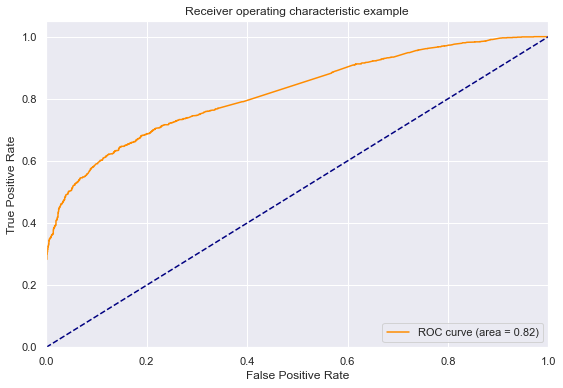

In [503]:
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [504]:
conf_matrix


array([[1256,  236],
       [ 463,  860]], dtype=int64)

In [505]:
feature_importances = best_clf.feature_importances_

In [506]:
feature_importances_df = pd.DataFrame({'features':list(X_train),'feature_importances':feature_importances})

In [507]:
feature_importances_df.sort_values('feature_importances', ascending = False)

,features,feature_importances
2,correct,0.310554
1,steps_tried,0.204641
5,viewed,0.168749
6,passed,0.162873
0,days,0.094050
4,correst_ratio,0.041935
3,wrong,0.017199
